In [45]:
import pandas as pd

df = pd.read_csv('./data/train_df.csv', index_col=0)
train_data = df.loc[(df.time < '2018-01-01')]
backtest_data = df.loc[(df.time >= '2018-02-01')]

etf_list = train_data.code.drop_duplicates().sort_values().values
df.head(10)
etf_list

array(['159905.XSHE', '159915.XSHE', '159928.XSHE', '159929.XSHE',
       '159934.XSHE', '510050.XSHG', '510300.XSHG', '510500.XSHG'],
      dtype=object)

In [88]:
import talib 
from functools import reduce


def cross_over(x, y, data):
    data[f'RSI_{x} - RSI_{y}'] = data[f'RSI_{x}'] - data[f'RSI_{y}'] 
    data[f'MA_{x} - MA_{y}'] = data[f'MA_{x}'] - data[f'MA_{y}'] 
    data[f'SMA_{x} - SMA_{y}'] = data[f'SMA_{x}'] - data[f'SMA_{y}'] 
    data[f'AROONOSC_{x} - AROONOSC_{y}'] = data[f'AROONOSC_{x}'] - data[f'AROONOSC_{y}']
    return y

def compute_rank_daily(data):
    data['target'] = data.groupby("time")['pct_change'].rank()
    return data

def get_target_level(target):
    if target > 0.02:
        return 2
    if target > 0.01:
        return 1
    if target > 0:
        return 0
    if target < 0.005:
        return -1
    if target < 0.01:
        return -2


def get_features(data):
    tech_data = pd.DataFrame(index=data.index);
    days = range(2, 10)
    for t in days:
        tech_data[f'BETA_{t}'] = talib.BETA(data.high, data.low, timeperiod=t)
        tech_data[f'SMA_{t}'] = talib.SMA(data.close,timeperiod=t)
        tech_data[f'RSI_{t}'] = talib.RSI(data.close, timeperiod=t)
        tech_data[f'MOM_{t}'] = talib.MOM(data.close, timeperiod=t)
        tech_data[f'MA_{t}'] = talib.MA(data.close, timeperiod=t)
        tech_data[f'CCI_{t}'] = talib.CCI(data.high, data.low, data.close, timeperiod=t)
        tech_data[f'DX_{t}'] = talib.DX(data.high, data.low, data.close, timeperiod=t)
        tech_data[f'volatility_{t}'] = data.close.pct_change(periods=t).std()
        tech_data[f'ADX_{t}'] = talib.ADX(data.high, data.low, data.close, timeperiod=t)
        tech_data[f'ADXR_{t}'] = talib.ADXR(data.high, data.low, data.close, timeperiod=t)
        tech_data[f'AROONOSC_{t}'] = talib.AROONOSC(data.high, data.low, timeperiod=t)
        tech_data[f'ROC_{t}'] = talib.ROC(data.close, timeperiod=t)
        tech_data[f'BIAS_{t}'] = (data['close'] - data['close'].rolling(t, min_periods=1).mean())/ data['close'].rolling(t, min_periods=1).mean()*100
        tech_data[f'BOLL_upper_{t}'], tech_data[f'BOLL_middle_{t}'], tech_data[f'BOLL_lower_{t}'] = talib.BBANDS(
                data.close,
                timeperiod=t,
                nbdevup=2,
                nbdevdn=2,
                matype=0)

    tech_data['SAR'] = talib.SAR(data.high, data.low)
    tech_data['AD'] = talib.AD(data.high, data.low, data.close, data.volume)
    tech_data['OBV'] = talib.OBV(data.close, data.volume)
    tech_data['MACD'], tech_data['MACDSIGNAL'], tech_data['MACDHIST'] = talib.MACD(data.close, fastperiod=12, slowperiod=26, signalperiod=9)
    
    tech_data['code'] = data.code
    tech_data['target'] = data.close.pct_change().shift(-1).apply(get_target_level)
    tech_data['time'] = data.time
        
#     reduce(lambda x,y: cross_over(x, y, tech_data), days)
    
    features = list(set(tech_data.columns) - set(data.columns) - set(['target'])) 
    return tech_data.dropna(), features



data_sets = pd.DataFrame()
features = []
for i in etf_list:
    etf_data, etf_features = get_features(train_data[train_data.code == i])
    data_sets = pd.concat([data_sets, etf_data])
    features = etf_features
    


## 对最后的数据集做处理
data_sets = data_sets.dropna()
data_sets = data_sets.set_index('code')
data_sets = data_sets.sort_values('time')
data_sets.tail(8)

,BETA_2,SMA_2,RSI_2,MOM_2,MA_2,CCI_2,DX_2,volatility_2,ADX_2,ADXR_2,...,BOLL_middle_9,BOLL_lower_9,SAR,AD,OBV,MACD,MACDSIGNAL,MACDHIST,target,time
code,,,,,,,,,,,,,,,,,,,,,
159929.XSHE,0.338515,1.5830,53.311319,-0.002,1.5830,66.666667,79.286468,0.027053,67.533456,61.656950,...,1.591222,1.573314,1.560932,3.243950e+08,3.319110e+08,0.002920,0.002261,0.000659,0.0,2017-12-28
510050.XSHG,-2.188196,3.5810,45.753248,-0.048,3.5810,0.000000,72.262445,0.023653,77.539367,80.177828,...,3.609333,3.553620,3.559000,3.285841e+10,3.053451e+10,0.001324,0.004823,-0.003499,0.0,2017-12-28
159934.XSHE,0.626108,2.7085,95.649715,0.010,2.7085,66.666667,98.982882,0.011525,93.455700,90.692109,...,2.693111,2.669363,2.663822,-1.767230e+08,4.157718e+08,-0.003543,-0.009216,0.005673,-1.0,2017-12-28
159928.XSHE,-1.791506,2.3400,50.859173,-0.043,2.3400,-66.666667,70.494676,0.025724,74.583764,76.628308,...,2.347778,2.285013,2.299101,1.411383e+08,1.908630e+08,0.042046,0.035082,0.006964,-1.0,2017-12-28
159915.XSHE,-6.058284,1.6335,43.185228,-0.007,1.6335,66.666667,97.412793,0.035454,95.009275,93.807516,...,1.655000,1.622096,1.685448,2.685512e+10,1.308263e+10,-0.020245,-0.019268,-0.000978,0.0,2017-12-28
159905.XSHE,0.671894,1.7225,58.659665,-0.007,1.7225,66.666667,68.327282,0.027732,60.888955,57.169792,...,1.728778,1.692084,1.769000,7.962869e+08,1.190363e+09,0.012911,0.010542,0.002368,0.0,2017-12-28
510300.XSHG,-3.021633,4.3740,52.487223,-0.034,4.3740,66.666667,87.978065,0.024943,78.704075,74.067081,...,4.405556,4.340549,4.470540,4.709556e+10,3.480966e+10,-0.007499,-0.005508,-0.001992,0.0,2017-12-28
510500.XSHG,0.000185,1.8235,53.509761,-0.008,1.8235,66.666667,91.040388,0.030692,87.798824,86.178042,...,1.832333,1.816784,1.860120,1.073570e+10,6.565597e+09,-0.014016,-0.015760,0.001744,1.0,2017-12-28


In [81]:
print('Features:')
display(features)

Features:


['CCI_7',
 'MOM_8',
 'MA_7',
 'BOLL_middle_8',
 'BOLL_middle_5',
 'ADX_6',
 'MOM_5',
 'AROONOSC_6',
 'MOM_7',
 'OBV',
 'RSI_5',
 'BOLL_lower_3',
 'MOM_6',
 'SAR',
 'volatility_8',
 'ROC_3',
 'BIAS_7',
 'ADXR_8',
 'volatility_2',
 'BOLL_lower_7',
 'BOLL_lower_8',
 'MOM_3',
 'CCI_4',
 'BOLL_lower_2',
 'ROC_6',
 'AD',
 'BOLL_lower_4',
 'ADXR_3',
 'SMA_8',
 'MA_6',
 'DX_4',
 'volatility_4',
 'CCI_3',
 'BOLL_middle_7',
 'CCI_5',
 'RSI_9',
 'ADX_8',
 'ADX_9',
 'SMA_4',
 'ROC_8',
 'AROONOSC_4',
 'SMA_2',
 'ROC_4',
 'MACD',
 'AROONOSC_8',
 'BETA_5',
 'RSI_4',
 'volatility_7',
 'MACDSIGNAL',
 'BETA_3',
 'DX_7',
 'BOLL_upper_8',
 'volatility_9',
 'RSI_3',
 'ADXR_2',
 'ROC_5',
 'CCI_6',
 'MACDHIST',
 'BIAS_4',
 'AROONOSC_3',
 'ADX_2',
 'BETA_7',
 'MA_8',
 'MA_5',
 'BOLL_middle_3',
 'BOLL_upper_6',
 'AROONOSC_5',
 'AROONOSC_2',
 'CCI_8',
 'DX_2',
 'ROC_7',
 'BETA_9',
 'SMA_7',
 'ROC_9',
 'BOLL_upper_7',
 'MOM_9',
 'RSI_7',
 'RSI_8',
 'BETA_4',
 'ADXR_5',
 'MA_9',
 'BIAS_9',
 'BETA_2',
 'ADX_4',
 '

In [132]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression, LassoCV
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import classification_report



def save_model(model, filename):
    import pickle
    from six import BytesIO
    pkl_file = open(filename, 'wb')
    pickle.dump(model, pkl_file, 0)
    pkl_file.close()


date = data_sets.index.drop_duplicates()

# data_sets = data_sets.loc[data_sets.index.isin(date[::2])]

## propressing

data_sets.tail(10)

,BETA_2,SMA_2,RSI_2,MOM_2,MA_2,CCI_2,DX_2,volatility_2,ADX_2,ADXR_2,...,BOLL_middle_9,BOLL_lower_9,SAR,AD,OBV,MACD,MACDSIGNAL,MACDHIST,target,time
code,,,,,,,,,,,,,,,,,,,,,
159905.XSHE,0.383282,1.7260,10.675827,-0.039,1.7260,-66.666667,54.115357,0.027732,53.450628,53.118264,...,1.722778,1.675367,1.696592,7.944336e+08,1.183948e+09,0.012717,0.009950,0.002767,1.0,2017-12-27
510300.XSHG,-1.435458,4.3910,11.650270,-0.061,4.3910,-66.666667,87.582456,0.024943,69.430086,60.353902,...,4.401000,4.328123,4.473000,4.701030e+10,3.463033e+10,-0.006963,-0.005010,-0.001953,0.0,2017-12-27
159929.XSHE,0.338515,1.5830,53.311319,-0.002,1.5830,66.666667,79.286468,0.027053,67.533456,61.656950,...,1.591222,1.573314,1.560932,3.243950e+08,3.319110e+08,0.002920,0.002261,0.000659,0.0,2017-12-28
510050.XSHG,-2.188196,3.5810,45.753248,-0.048,3.5810,0.000000,72.262445,0.023653,77.539367,80.177828,...,3.609333,3.553620,3.559000,3.285841e+10,3.053451e+10,0.001324,0.004823,-0.003499,0.0,2017-12-28
159934.XSHE,0.626108,2.7085,95.649715,0.010,2.7085,66.666667,98.982882,0.011525,93.455700,90.692109,...,2.693111,2.669363,2.663822,-1.767230e+08,4.157718e+08,-0.003543,-0.009216,0.005673,-1.0,2017-12-28
159928.XSHE,-1.791506,2.3400,50.859173,-0.043,2.3400,-66.666667,70.494676,0.025724,74.583764,76.628308,...,2.347778,2.285013,2.299101,1.411383e+08,1.908630e+08,0.042046,0.035082,0.006964,-1.0,2017-12-28
159915.XSHE,-6.058284,1.6335,43.185228,-0.007,1.6335,66.666667,97.412793,0.035454,95.009275,93.807516,...,1.655000,1.622096,1.685448,2.685512e+10,1.308263e+10,-0.020245,-0.019268,-0.000978,0.0,2017-12-28
159905.XSHE,0.671894,1.7225,58.659665,-0.007,1.7225,66.666667,68.327282,0.027732,60.888955,57.169792,...,1.728778,1.692084,1.769000,7.962869e+08,1.190363e+09,0.012911,0.010542,0.002368,0.0,2017-12-28
510300.XSHG,-3.021633,4.3740,52.487223,-0.034,4.3740,66.666667,87.978065,0.024943,78.704075,74.067081,...,4.405556,4.340549,4.470540,4.709556e+10,3.480966e+10,-0.007499,-0.005508,-0.001992,0.0,2017-12-28


### Feature Selection

In [136]:
X = data_sets[features]
y = data_sets['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# rest_len = len(X) % len(etf_list)
# X_train, X_test = np.split(X, [int(.67 *len(X)) - rest_len])
# y_train, y_test = np.split(y, [int(.67 *len(y)) - rest_len])

svm_parameters = {
    'regressor__n_estimators': (120, 130, 140, 150),
#     'regressor__max_depth': (2, 3, 4)
}

pipline = Pipeline([
    ('scale', MinMaxScaler()),
    ('feature_selection', SelectKBest(chi2)),
    ('feature process',PCA()),
    ('regressor', AdaBoostClassifier(random_state=44))
])

svm = GridSearchCV(pipline, svm_parameters, cv=3, n_jobs=4)


svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

print('参数:', svm.best_params_)
print('R方值:', accuracy_score(y_test, svm_pred))

参数: {'regressor__n_estimators': 120}
R方值: 0.4887550200803213


In [137]:
svm.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scale', MinMaxScaler()),
                                       ('feature_selection',
                                        SelectKBest(score_func=<function chi2 at 0x7fbc82abe550>)),
                                       ('feature process', PCA()),
                                       ('regressor',
                                        AdaBoostClassifier(random_state=44))]),
             n_jobs=4,
             param_grid={'regressor__n_estimators': (120, 130, 140, 150)})

In [140]:
import datetime
import backtrader as bt
import backtrader.feeds as btfeed


class MLStrategy(bt.Strategy):
    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def __init__(self):
        self.position_list = []
        

    def next(self):
        today = self.datas[0].datetime.date(0).isoformat()
        signal_list = pd.DataFrame()   
        today_df = df[(df.time < today)] 

        
        for index, e in enumerate(etf_list):
            etf_data, etf_features = get_features(today_df[today_df.code == e])
            etf_data = etf_data.dropna()
            signal = svm.predict(etf_data[etf_features])

            today_signal = signal[-1]
            
            if (today_signal > 0): 
                signal_list.loc[index, 'increase'] = today_signal
            
        if len(signal_list):
            buy_list = signal_list.sort_values('increase').tail(3).index
            sell_list = set(self.position_list) - set(buy_list) 
            self.position_list = list(buy_list)
            
            self.log('buy_list: %s' % buy_list)
            self.log('sell_list: %s' % sell_list)
            
            for sell_index in sell_list:
                self.close(self.datas[sell_index])
            
            for buy_index in self.position_list:
                self.order_target_percent(data=self.datas[buy_index], target=1.00 / len(buy_list))
                

#         if len(self) % 30 == 0:
#             pred_data, _ = get_features(df.loc[df.time < today])
#             pred_data = pred_data.dropna()
#             pred_data = pred_data.set_index('code')
#             pred_data = pred_data.sort_values('time')
#             pred_data_y = pred_data['target']
#             pred_data_x = pred_data[features]
#             svm.fit(pred_data_x, pred_data_y)
#             print('fit model again')


Starting Portfolio Value: 100000.00
2018-02-01, buy_list: Int64Index([1, 4, 5], dtype='int64')
2018-02-01, sell_list: set()
2018-02-02, buy_list: Int64Index([4, 5], dtype='int64')
2018-02-02, sell_list: {1}
2018-02-05, buy_list: Int64Index([4], dtype='int64')
2018-02-05, sell_list: {5}
2018-02-06, buy_list: Int64Index([4, 5], dtype='int64')
2018-02-06, sell_list: set()
2018-02-07, buy_list: Int64Index([4, 5], dtype='int64')
2018-02-07, sell_list: set()
2018-02-08, buy_list: Int64Index([4], dtype='int64')
2018-02-08, sell_list: {5}
2018-02-09, buy_list: Int64Index([1, 4], dtype='int64')
2018-02-09, sell_list: set()
2018-02-12, buy_list: Int64Index([7, 4, 5], dtype='int64')
2018-02-12, sell_list: {1}
2018-02-13, buy_list: Int64Index([4, 7], dtype='int64')
2018-02-13, sell_list: {5}
2018-02-14, buy_list: Int64Index([4, 7], dtype='int64')
2018-02-14, sell_list: set()
2018-02-22, buy_list: Int64Index([4, 7], dtype='int64')
2018-02-22, sell_list: set()
2018-02-23, buy_list: Int64Index([2, 4]

2018-07-03, buy_list: Int64Index([4, 7], dtype='int64')
2018-07-03, sell_list: {1}
2018-07-04, buy_list: Int64Index([4, 7], dtype='int64')
2018-07-04, sell_list: set()
2018-07-05, buy_list: Int64Index([4, 7], dtype='int64')
2018-07-05, sell_list: set()
2018-07-06, buy_list: Int64Index([4, 7], dtype='int64')
2018-07-06, sell_list: set()
2018-07-09, buy_list: Int64Index([4, 5, 7], dtype='int64')
2018-07-09, sell_list: set()
2018-07-10, buy_list: Int64Index([4, 5, 7], dtype='int64')
2018-07-10, sell_list: set()
2018-07-11, buy_list: Int64Index([4, 5, 7], dtype='int64')
2018-07-11, sell_list: set()
2018-07-12, buy_list: Int64Index([4, 5, 7], dtype='int64')
2018-07-12, sell_list: set()
2018-07-13, buy_list: Int64Index([4, 5, 7], dtype='int64')
2018-07-13, sell_list: set()
2018-07-16, buy_list: Int64Index([4, 7], dtype='int64')
2018-07-16, sell_list: {5}
2018-07-17, buy_list: Int64Index([4, 7], dtype='int64')
2018-07-17, sell_list: set()
2018-07-18, buy_list: Int64Index([4, 5, 7], dtype='int

2018-11-22, buy_list: Int64Index([3, 4, 7], dtype='int64')
2018-11-22, sell_list: set()
2018-11-23, buy_list: Int64Index([3, 4, 7], dtype='int64')
2018-11-23, sell_list: set()
2018-11-26, buy_list: Int64Index([3, 4, 7], dtype='int64')
2018-11-26, sell_list: set()
2018-11-27, buy_list: Int64Index([3, 4, 7], dtype='int64')
2018-11-27, sell_list: set()
2018-11-28, buy_list: Int64Index([3, 4, 7], dtype='int64')
2018-11-28, sell_list: set()
2018-11-29, buy_list: Int64Index([3, 4, 7], dtype='int64')
2018-11-29, sell_list: set()
2018-11-30, buy_list: Int64Index([3, 4, 7], dtype='int64')
2018-11-30, sell_list: set()
2018-12-03, buy_list: Int64Index([3, 4, 7], dtype='int64')
2018-12-03, sell_list: set()
2018-12-04, buy_list: Int64Index([3, 4, 7], dtype='int64')
2018-12-04, sell_list: set()
2018-12-05, buy_list: Int64Index([3, 4, 7], dtype='int64')
2018-12-05, sell_list: set()
2018-12-06, buy_list: Int64Index([3, 4, 7], dtype='int64')
2018-12-06, sell_list: set()
2018-12-07, buy_list: Int64Index

2019-04-16, buy_list: Int64Index([1, 4, 7], dtype='int64')
2019-04-16, sell_list: set()
2019-04-17, buy_list: Int64Index([1, 4, 7], dtype='int64')
2019-04-17, sell_list: set()
2019-04-18, buy_list: Int64Index([1, 4, 7], dtype='int64')
2019-04-18, sell_list: set()
2019-04-19, buy_list: Int64Index([3, 4, 7], dtype='int64')
2019-04-19, sell_list: {1}
2019-04-22, buy_list: Int64Index([1, 4, 7], dtype='int64')
2019-04-22, sell_list: {3}
2019-04-23, buy_list: Int64Index([1, 4, 7], dtype='int64')
2019-04-23, sell_list: set()
2019-04-24, buy_list: Int64Index([4, 7], dtype='int64')
2019-04-24, sell_list: {1}
2019-04-25, buy_list: Int64Index([1, 4, 7], dtype='int64')
2019-04-25, sell_list: set()
2019-04-26, buy_list: Int64Index([3, 4, 7], dtype='int64')
2019-04-26, sell_list: {1}
2019-04-29, buy_list: Int64Index([1, 4, 7], dtype='int64')
2019-04-29, sell_list: {3}
2019-04-30, buy_list: Int64Index([1, 4, 7], dtype='int64')
2019-04-30, sell_list: set()
2019-05-06, buy_list: Int64Index([1, 4, 7], d

2019-09-02, buy_list: Int64Index([4, 7], dtype='int64')
2019-09-02, sell_list: set()
2019-09-03, buy_list: Int64Index([4, 7], dtype='int64')
2019-09-03, sell_list: set()
2019-09-04, buy_list: Int64Index([1, 4, 7], dtype='int64')
2019-09-04, sell_list: set()
2019-09-05, buy_list: Int64Index([4, 7], dtype='int64')
2019-09-05, sell_list: {1}
2019-09-06, buy_list: Int64Index([4, 7], dtype='int64')
2019-09-06, sell_list: set()
2019-09-09, buy_list: Int64Index([4, 7], dtype='int64')
2019-09-09, sell_list: set()
2019-09-10, buy_list: Int64Index([4, 7], dtype='int64')
2019-09-10, sell_list: set()
2019-09-11, buy_list: Int64Index([4, 7], dtype='int64')
2019-09-11, sell_list: set()
2019-09-12, buy_list: Int64Index([4, 7], dtype='int64')
2019-09-12, sell_list: set()
2019-09-16, buy_list: Int64Index([4, 7], dtype='int64')
2019-09-16, sell_list: set()
2019-09-17, buy_list: Int64Index([4, 7], dtype='int64')
2019-09-17, sell_list: set()
2019-09-18, buy_list: Int64Index([4, 7], dtype='int64')
2019-09-

2020-02-03, buy_list: Int64Index([4, 7], dtype='int64')
2020-02-03, sell_list: set()
2020-02-04, buy_list: Int64Index([4, 7], dtype='int64')
2020-02-04, sell_list: set()
2020-02-05, buy_list: Int64Index([4, 7], dtype='int64')
2020-02-05, sell_list: set()
2020-02-06, buy_list: Int64Index([4, 7], dtype='int64')
2020-02-06, sell_list: set()
2020-02-07, buy_list: Int64Index([4], dtype='int64')
2020-02-07, sell_list: {7}
2020-02-10, buy_list: Int64Index([3, 4, 7], dtype='int64')
2020-02-10, sell_list: set()
2020-02-11, buy_list: Int64Index([4], dtype='int64')
2020-02-11, sell_list: {3, 7}
2020-02-12, buy_list: Int64Index([4, 7], dtype='int64')
2020-02-12, sell_list: set()
2020-02-13, buy_list: Int64Index([4, 7], dtype='int64')
2020-02-13, sell_list: set()
2020-02-14, buy_list: Int64Index([4], dtype='int64')
2020-02-14, sell_list: {7}
2020-02-17, buy_list: Int64Index([4, 7], dtype='int64')
2020-02-17, sell_list: set()
2020-02-18, buy_list: Int64Index([4, 7], dtype='int64')
2020-02-18, sell_l

<IPython.core.display.Javascript object>


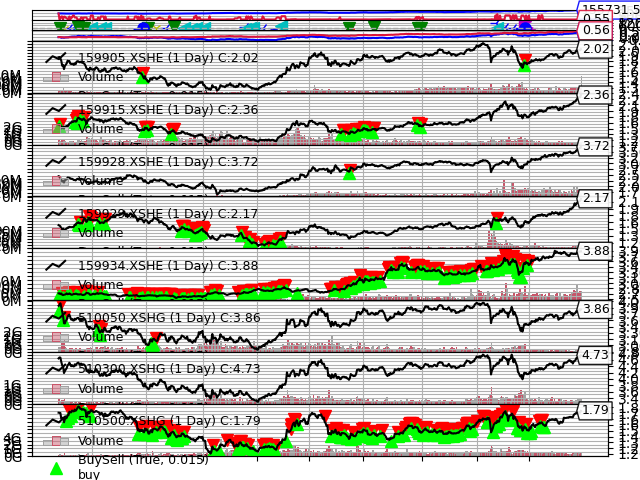

[[<Figure size 640x480 with 19 Axes>]]

In [141]:
# Create a cerebro entity
cerebro = bt.Cerebro()
backtest_data = df.loc[(df.time >= '2018-02-01') & (df.time < '2020-07-01')]

for etf in etf_list:
    etf_data = backtest_data[backtest_data.code == etf]
    etf_data = etf_data[['time', 'open', 'high', 'low', 'close', 'volume']]
    etf_data = etf_data.set_index('time')
    etf_data.index = pd.to_datetime(etf_data.index)
    etf_data = bt.feeds.PandasData(dataname=etf_data)
    cerebro.adddata(etf_data, etf)
    if etf == '159915.XSHE':
        benchdata = etf_data

        
# Add a strategy
cerebro.addstrategy(MLStrategy)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
cerebro.addobserver(bt.observers.Benchmark,
                            data=benchdata,
                            timeframe=bt.TimeFrame.NoTimeFrame)
cerebro.broker.setcash(100000.0)
 

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run()
strat = results[0]

print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
%matplotlib notebook

cerebro.plot()

### Backtesting Analyzers

In [12]:
import pyfolio as pf

pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()

# pf.create_full_tear_sheet(
#     returns=returns,
#     positions=positions,
#     transactions=transactions,
#     live_start_date='2019-02-01',
# )
positions


ModuleNotFoundError: No module named 'pyfolio'

In [195]:
rdf_parameters = {
    'classification__n_estimators':(140, 150, 160, 170, 180), 
    'classification__max_depth':[4, 5, 6, 7]
}

pipline = Pipeline([    
    ('feature_selection', SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))),
    ('classification', RandomForestClassifier())
])

rdf = GridSearchCV(pipline, rdf_parameters, cv=5)


rdf.fit(X_train, y_train)
rdf_pred = rdf.predict(X_test)
print('参数:', rdf.best_params_)
print('准确率:', accuracy_score(y_test, rdf_pred))
print('分类报告:', classification_report(y_test, rdf_pred))

NameError: name 'RandomForestClassifier' is not defined

<IPython.core.display.Javascript object>


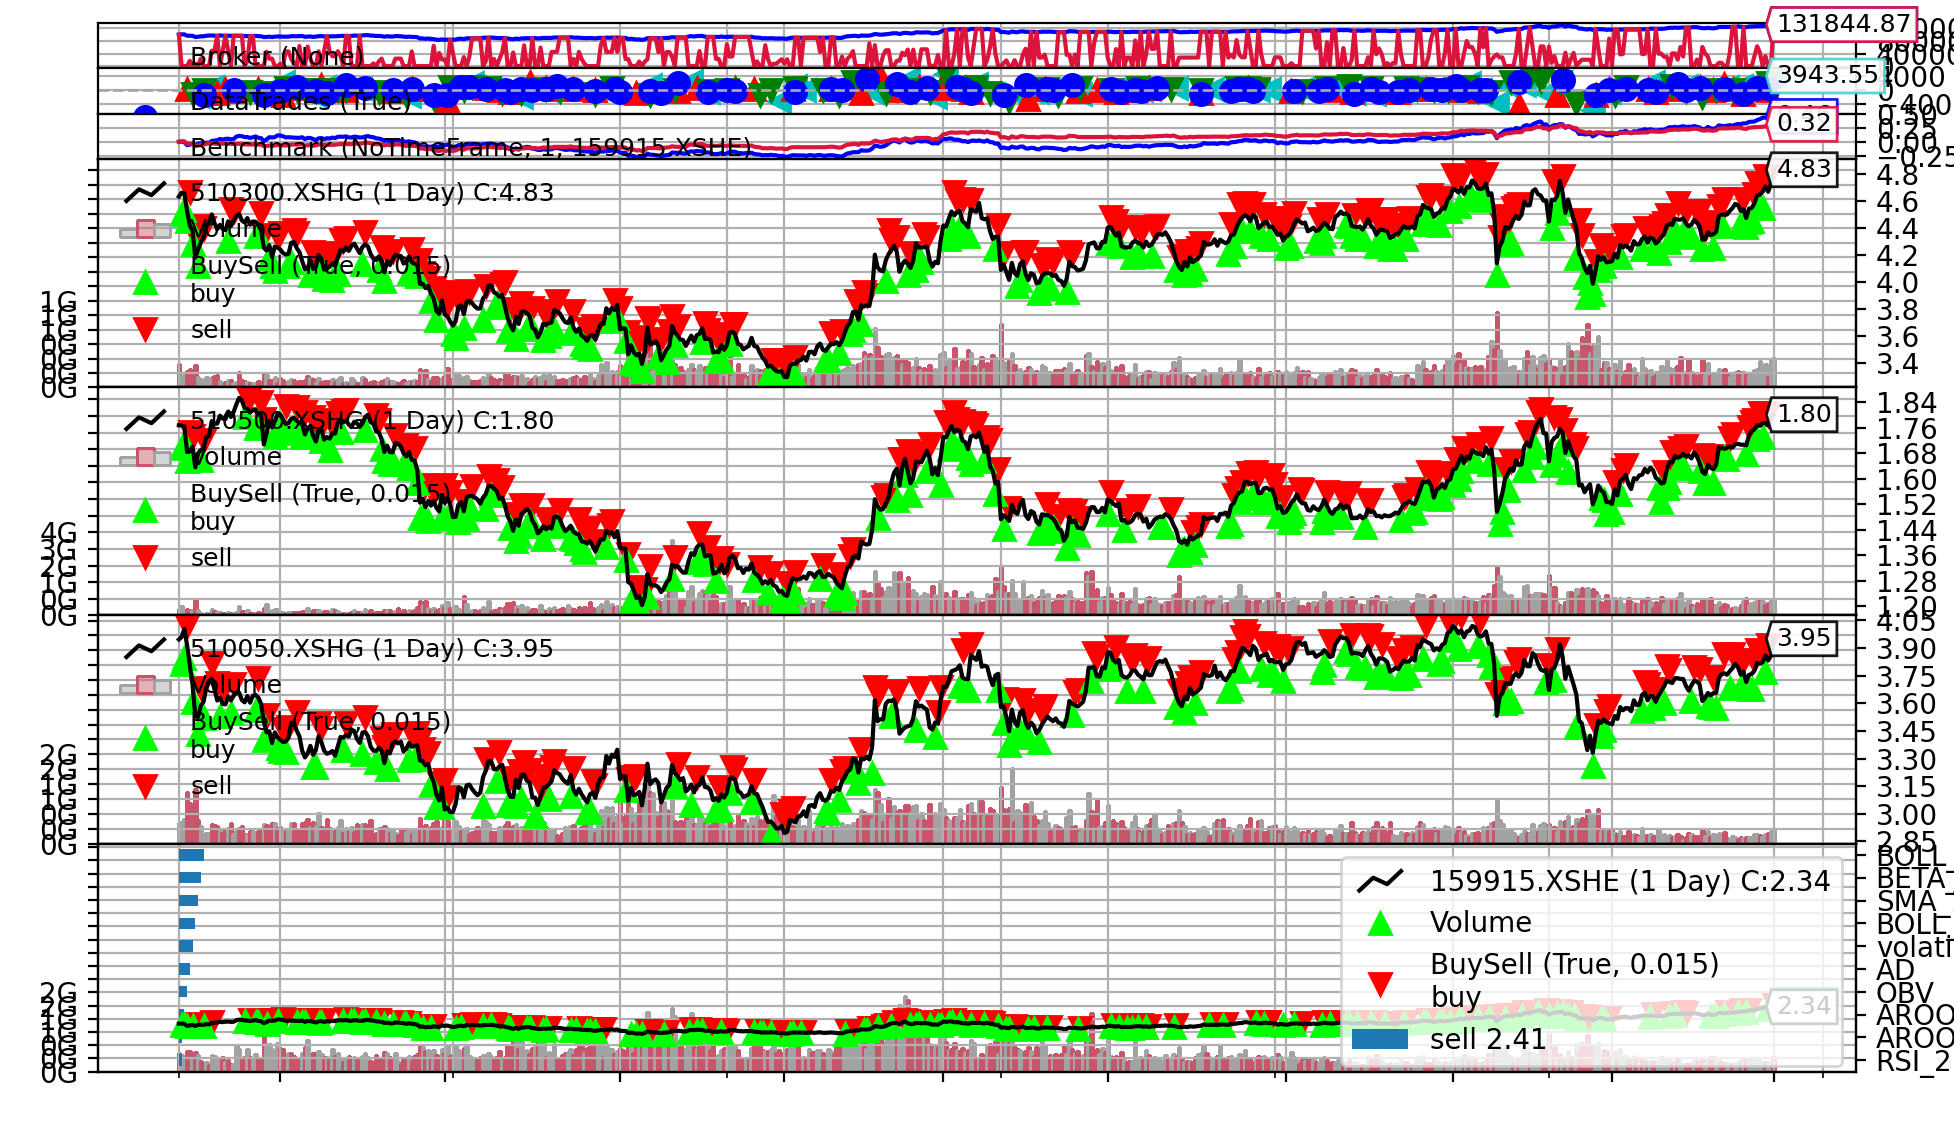

[[<Figure size 640x480 with 11 Axes>]]

In [74]:
%matplotlib notebook
cerebro.plot()

<IPython.core.display.Javascript object>


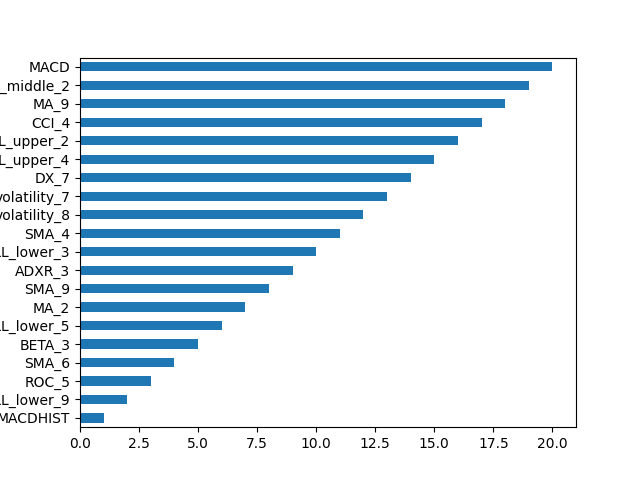

array([[-0.75503767],
       [-0.37787018],
       [-0.47292227],
       ...,
       [-0.23537507],
       [-0.22822162],
       [-0.27094771]])

In [36]:
X = data_sets[features]
y = data_sets['target']

selector = RFECV(Lasso(random_state=50), cv=3, n_jobs=4)
selector = selector.fit(X, y)

%matplotlib notebook
feat_importances = pd.Series(selector.ranking_, index=X.columns)
feat_importances.nsmallest(20).plot(kind='barh')

X = selector.transform(X)
rest_len = int(.67 *len(X)) % len(etf_list)
X_train, X_test = np.split(X, [int(.67 *len(X)) - rest_len])
y_train, y_test = np.split(y, [int(.67 *len(y)) - rest_len])
X = data_sets[features]
y = data_sets['target']
X_train